In [1]:
%matplotlib inline

# 難以忘記你容顏 (pytorch)

![md_images](../Images/faces.png)

In [2]:
#如果電腦環境沒有安裝face_recognition，請使用以下語法安裝，僅需安裝一次即可
#安裝過程很久大概20分鐘
#會連同dlib一併安裝完成
#!pip install face_recognition
#!pip install imutils

<img src="../Images/avengers.jpg",width=500>

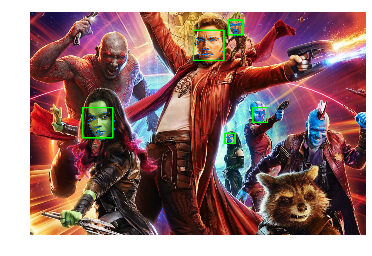

In [3]:
import dlib
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import imutils
from imutils.face_utils import *

#宣告臉部偵測器，以及載入預訓練的臉部特徵點模型
detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('../Data/ex07_train/shape_predictor_68_face_landmarks.dat')

img = cv2.imread('../Images/avengers.jpg')
#產生臉部識別
face_rects = detector(img, 1)
for i, d in enumerate(face_rects):
    #讀取框左上右下座標
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()
    #根據此座標範圍讀取臉部特徵點
    shape = landmark_predictor(img, d)
    #將特徵點轉為numpy
    shape = shape_to_np(shape)# (68,2)
    #按照特徵點畫圓
    for (x, y) in shape:
        cv2.circle(img, (x, y), 2, (215, 120, 0), -1)
    #在臉部位置打框
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)
#要顯示圖形前，需要將BGR轉RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

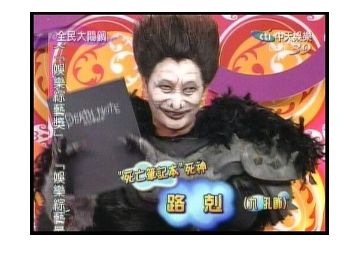

In [4]:
img = Image.open('../Images/luke.jpg')
plt.axis('off')
plt.imshow(img)

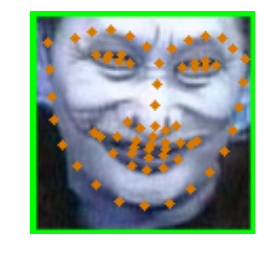

In [5]:
img = cv2.imread('../Images/luke.jpg')
#產生臉部識別
face_rects = detector(img, 1)
for i, d in enumerate(face_rects):
    #讀取框左上右下座標
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()
    #根據此座標範圍讀取臉部特徵點
    shape = landmark_predictor(img, d)
    #將特徵點轉為numpy
    shape = shape_to_np(shape)# (68,2)
    #按照特徵點畫圓
    for (x, y) in shape:
        cv2.circle(img, (x, y), 2, (215, 120, 0), -1)
    #在臉部位置打框
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)
    crop_img = img[y1:y2, x1:x2, :]
    #要顯示圖形前，需要將BGR轉RGB
    img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(crop_img)

In [6]:
import os
import pickle
import codecs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<img src="../Images/maydays.jpg",width=450>

<img src="../Images/SCUT-FBP5500.jpg",width=750>

In [7]:
#讀取評分數據
rating_dict={}
f=codecs.open('../Data/ex07_train/All_Ratings.txt',encoding='utf-8-sig').readlines()
#'ftw1.jpg	 4.117
for row in f:
    data=row.replace('\r\n','').split('\t')
    rating_dict['images\\'+data[0]]=float(data[1])

#讀取圖片數據
images_dict={}
with open('../Data/ex07_train/images_dict.pkl', 'rb') as fp:
    images_dict=pickle.load(fp)

In [8]:
idx=0
idx1=0
idxs=list(images_dict.keys())
random.shuffle(idxs) #打亂順序
train_idxs=idxs[:4000]#定義訓練集索引
test_idxs=idxs[4000:]#定義測試集索引


def next_minibatch(minibatch_size,is_train=True):
    global idx,idx1,train_idxs,test_idxs
    features = []
    labels_keypoins=[]
    labels_rating=[]
    labels_gender=[]
    while len(features) < minibatch_size:
        try:
            if is_train:
                img = images_dict[train_idxs[idx]][0].astype(np.float32)
                img = img.transpose(2, 0, 1)  # 轉成CHW
                img = np.ascontiguousarray(img[::-1])  # 顏色排序為BGR
                
                keypoints = np.reshape(images_dict[train_idxs[idx]][1].astype(np.float32),-1)/255.
                if train_idxs[idx] in rating_dict:
                    rating=(rating_dict[train_idxs[idx]]-1)/4. #(原始分數-1)/4因為原始顏值為1~5分
                    gender=np.eye(2)[0 if train_idxs[idx].split('\\')[-1][0]=="f" else 1]
                    img = img / 255. #將圖片除以255，讓向量介於0~1
                    features.append(img)
                    labels_keypoins.append(keypoints)
                    labels_rating.append(np.asarray([rating]).astype(np.float32))
                    labels_gender.append(gender.astype(np.float32))
            else:
                img = images_dict[test_idxs[idx1]][0].astype(np.float32)
                img = img.transpose(2, 0, 1)  # 轉成CHW
                img = np.ascontiguousarray(img[::-1])  # 顏色排序為BGR
                keypoints = np.reshape(images_dict[test_idxs[idx1]][1].astype(np.float32),-1)/255.
                if test_idxs[idx1] in rating_dict:
                    rating = (rating_dict[test_idxs[idx1]]-1)/4
                    gender = np.eye(2)[0 if test_idxs[idx1].split('\\')[-1][0] == "f" else 1]
                    img = img / 255.  # 將圖片除以255，讓向量介於0~1
                    features.append(img)
                    labels_keypoins.append(keypoints)
                    labels_rating.append(np.asarray([rating]).astype(np.float32))
                    labels_gender.append(gender.astype(np.float32))
        except OSError as e:
            print(e)
        if is_train:
            idx+=1
            if idx>=len(train_idxs): #如果取圖片序號超過
                random.shuffle(train_idxs)
                idx = 0
        else:
            idx1 += 1
            if idx1 >= len(test_idxs):  # 如果取圖片序號超過
                random.shuffle(test_idxs)
                idx1 = 0
    return np.asarray(features).astype(np.float32),np.asarray(labels_rating).astype(np.float32)

In [9]:
#圖片轉向量
def img2array(img: Image):
    arr = np.array(img).astype(np.float32)
    arr=arr.transpose(2, 0, 1) #轉成CHW
    arr=arr[::-1] #顏色排序為BGR
    return np.ascontiguousarray(arr)

#向量轉圖片
def array2img(arr: np.ndarray):
    sanitized_img =arr[::-1]#轉成RGB
    sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))#轉成HWC
    img = Image.fromarray(sanitized_img.astype(np.uint8))
    return img


In [10]:
class DenseLayer(nn.Sequential): 
    def __init__(self, in_channels, growth_rate): 
        super().__init__() 
        self.add_module('norm', nn.BatchNorm2d(in_channels)) 
        self.add_module('relu', nn.LeakyReLU(inplace=True)) 
        self.add_module('conv', nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=True)) 
        self.add_module('drop', nn.Dropout2d(0.0)) 
    def forward(self, x): 
        return super().forward(x)  

class DenseBlock(nn.Module): 
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False): 
        super().__init__() 
        self.upsample = upsample 
        self.layers = nn.ModuleList([DenseLayer( 
            in_channels + i*growth_rate, growth_rate) 
            for i in range(n_layers)]) 
    def forward(self, x): 
        if self.upsample: 
            new_features = [] 
            #we pass all previous activations into each dense layer normally 
            #But we only store each dense layer's output in the new_features array 
            for layer in self.layers: 
                out = layer(x) 
                x = torch.cat([x, out], 1) 
                new_features.append(out) 
            return torch.cat(new_features,1) 
        else: 
            for layer in self.layers: 
                out = layer(x) 
                x = torch.cat([x, out], 1) # 1 = channel axis 
            return x 

class TransitionDown(nn.Sequential): 
    def __init__(self, in_channels): 
        super().__init__() 
        self.add_module('conv', nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=2, padding=0, bias=True)) 
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels)) 
        self.add_module('relu', nn.LeakyReLU(inplace=True)) 
    def forward(self, x): 
        return super().forward(x) 

class DenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 growth_rate=16, out_chans_first_conv=32):
        super().__init__()
        self.down_blocks = down_blocks
        self.leakyrelu=nn.LeakyReLU(inplace=True)
        cur_channels_count = 0
        skip_connection_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        ## Softmax ##

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=256, kernel_size=1, stride=1,
                   padding=0, bias=True)
        self.fc1 = nn.Linear(256*16*16,64)
        self.fc2 = nn.Linear(64,1)
        self.sigmoid=nn.Sigmoid()



    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
        out = self.finalConv(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.leakyrelu(out)
        out=self.fc2(out)
        out=self.sigmoid(out)
        return out



def weights_init(m): 
    if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_uniform_(m.weight) 
        m.bias.data.zero_() 



In [11]:
num_epochs=2
minibatch_size=4
learning_rate =1e-4 # 學習速率 
model =DenseNet(in_channels=3, down_blocks=(4,4,4,4), growth_rate=16, out_chans_first_conv=32)
if os.path.exists('Models/beauty_detector_pytorch.cnn'):
    model=torch.load('Models/beauty_detector_pytorch.cnn')
    print('載入既有模型累積訓練!!')
model=model.to(device)



optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=5e-5)
criterion=nn.MSELoss(reduction='sum')  #使用MSELoss


載入既有模型累積訓練!!


In [12]:
print('epoch start')
for epoch in range(num_epochs):
    mbs = 0
    trn_loss = 0
    trn_error = 0
    while mbs < 1000:
        raw_features, raw_rating= next_minibatch(minibatch_size)
        #讀取數據
        input, target = torch.from_numpy(raw_features), torch.from_numpy(raw_rating)
        #將numpy轉為variable
        input, target = Variable(input), Variable(target)
        #轉換為cuda
        input, target = input.to(device), target.to(device) #使用GPU or CPU
        output = model(input)
        loss = criterion(output, target)

        optimizer.zero_grad()#這句一定要放在loss.backward()之前
        loss.backward()
        optimizer.step()
        trn_loss += loss.data.item()
        pred_beauty =output.cpu().detach().numpy()
        actual_beauty=raw_rating

        err =np.sqrt(np.mean(np.square(pred_beauty-actual_beauty)))
        trn_error += (err)

        if mbs % 100 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, num_epochs),
                  "Step: {} ".format(mbs),
                  "Loss: {:.4f} ".format(loss.data.item()),
                  "err: {:.3%}".format(err),
                  "實際顏值: {:.2f} ".format(np.mean(raw_rating)*100),
                  "預測顏值: {:.2f}".format(np.mean(pred_beauty)*100))
        if mbs % 100 == 0 and mbs>0:
            torch.save(model, 'Models/beauty_detector_pytorch.cnn')
        mbs += 1
    trn_loss /= 100
    trn_error /= 100
    torch.save(model, 'Models/beauty_detector_pytorch.cnn')


epoch start
Epoch: 1/2  Step: 0  Loss: 0.0048  err: 3.479% 實際顏值: 44.90  預測顏值: 46.44
Epoch: 1/2  Step: 100  Loss: 0.0267  err: 8.164% 實際顏值: 47.08  預測顏值: 49.37


C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DenseBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type DenseLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type TransitionDown. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1/2  Step: 200  Loss: 0.1202  err: 17.332% 實際顏值: 56.05  預測顏值: 46.05
Epoch: 1/2  Step: 300  Loss: 0.0222  err: 7.442% 實際顏值: 45.83  預測顏值: 50.73
Epoch: 1/2  Step: 400  Loss: 0.0363  err: 9.521% 實際顏值: 48.22  預測顏值: 50.92
Epoch: 1/2  Step: 500  Loss: 0.0086  err: 4.647% 實際顏值: 53.64  預測顏值: 52.25
Epoch: 1/2  Step: 600  Loss: 0.0179  err: 6.689% 實際顏值: 56.57  預測顏值: 62.14
Epoch: 1/2  Step: 700  Loss: 0.0521  err: 11.411% 實際顏值: 69.27  預測顏值: 60.36
Epoch: 1/2  Step: 800  Loss: 0.0790  err: 14.057% 實際顏值: 64.17  預測顏值: 53.92
Epoch: 1/2  Step: 900  Loss: 0.0350  err: 9.354% 實際顏值: 39.69  預測顏值: 47.29
Epoch: 2/2  Step: 0  Loss: 0.1077  err: 16.411% 實際顏值: 48.44  預測顏值: 41.16
Epoch: 2/2  Step: 100  Loss: 0.1260  err: 17.748% 實際顏值: 51.56  預測顏值: 59.82
Epoch: 2/2  Step: 200  Loss: 0.0124  err: 5.567% 實際顏值: 53.85  預測顏值: 51.04
Epoch: 2/2  Step: 300  Loss: 0.0038  err: 3.101% 實際顏值: 41.88  預測顏值: 39.80
Epoch: 2/2  Step: 400  Loss: 0.0629  err: 12.540% 實際顏值: 44.90  預測顏值: 55.13
Epoch: 2/2  Step: 500  Loss: 0.042

##請注意以下預訓練模型測試必須在gpu環境 

In [18]:
model=torch.load('pretrained_beauty_detector_pytorch.cnn')
model=model.to(device)
def check_face_beauty(file_path):
    if os.path.exists(file_path):
        test_img = cv2.imread(file_path)
        #產生臉部識別
        face_rects = detector(test_img, 1)
        if len(face_rects)>0:
            for i, d in enumerate(face_rects):
                #讀取框左上右下座標
                shape = landmark_predictor(test_img, d)
                shape = shape_to_np(shape)# (68,2)
                minxy,maxxy=np.min(shape,0),np.max(shape,0)
                x1=max(minxy[0],0)
                y1 = max(minxy[1]+2,0)
                x2 = min(maxxy[0],test_img.shape[1])
                y2 =  min(maxxy[1]+5,test_img.shape[0])
                crop_test_img = test_img[y1:y2, x1:x2, :]
                if x2<5 or y2<5 or crop_test_img.shape[0]<5 or crop_test_img.shape[1]<5:
                    print('臉部偵測異常')
                else:
                    #圖片不是直接強制縮放為256*256，否則臉可能會因為擠壓而失真
                    #先讓最長邊長等比例縮放至256，其餘填黑
                    width=crop_test_img.shape[1]
                    height=crop_test_img.shape[0]
                    scale=256/max(width,height)
                    crop_test_img = imutils.resize(crop_test_img, width=int(width*scale),height=int(height*scale))

                    #要顯示圖形前，需要將BGR轉RGB
                    plt.axis('off')
                    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
                    #要將cv2的圖像轉成我們要的結構
                    test_arr=cv2.cvtColor(crop_test_img, cv2.COLOR_BGR2RGB).transpose(2, 0, 1).astype(np.float32)
                    #用黑色補滿256*256
                    new_crop_img= np.zeros((3,256,256), np.float32)
                    new_crop_img[:,:test_arr.shape[1],:test_arr.shape[2]]=test_arr
                    #要除以255將數值控制在0~1之間
                    input=np.asarray([new_crop_img/255.])
                    input=torch.from_numpy(input)
                    input=Variable(input)
                    input=input.to(device)
                    output = model(input)
                    pred=np.mean(output.cpu().detach().numpy())
                    print('顏值為{0:.2f}分'.format(float(pred)*100.))
        else:
            print('偵測不到臉')
    else:
        print('圖片不存在')

顏值為70.30分


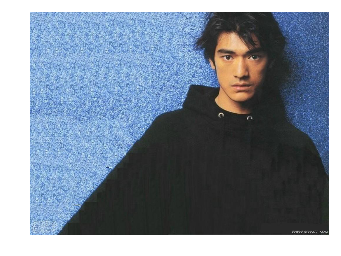

In [19]:
check_face_beauty('../Images/takeshi.jpg')

顏值為64.32分


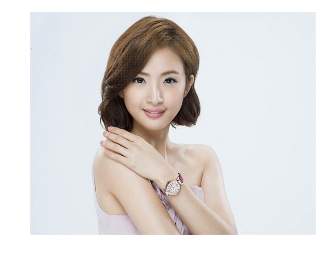

In [20]:
check_face_beauty('../Images/linyicheng.jpg')

顏值為33.38分


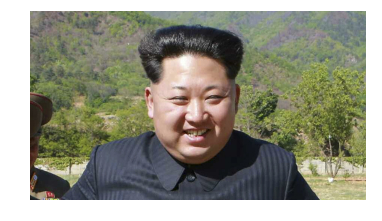

In [21]:
check_face_beauty('../Images/kim.jpg')

顏值為56.44分


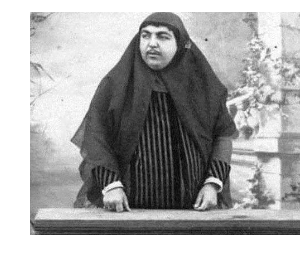

In [22]:
check_face_beauty('../Images/princess.jpg')